In [16]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super().__init__()
        self.disc = nn.Sequential(
            # Input: N x channels_img x 64 x 64
            nn.Conv2d(
                channels_img, features_d, kernel_size = 4, stride=2, padding=1
            ),
            # 32x32
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4,2,1),# 16 x 16
            self._block(features_d*2, features_d*4, 4,2,1), # 8 x 8
            self._block(features_d*4, features_d*8, 4,2,1), # 4 x 4
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0), # 1 x 1
            nn.Sigmoid()
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels, 
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, x):
        return self.disc(x)

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super().__init__()
        self.gen = nn.Sequential(
            # Input : N x z_dim x 1 x 1
            self._block(z_dim, features_g*16, 4,1,0), # N x f_g*16 x 4 x 4
            self._block(features_g*16, features_g*8, 4,2,1), # N x f_g*8 x 8 x 8
            self._block(features_g*8,  features_g*4, 4,2,1), # N x f_g*4 x 16 x 16
            self._block(features_g*4, features_g*2, 4,2,1), # N x f_g*2 x 32 x 32
            nn.ConvTranspose2d(
                features_g*2, channels_img, kernel_size=4, stride=2, padding=1
            ), # N x channels_img x 64 x 64
            nn.Tanh() , # [-1, 1]   
        )
        
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels, 
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
    def forward(self, x):
        return self.gen(x)

In [5]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [6]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1,1,1)
    gen = Generator(z_dim, in_channels, 8)
   # initialize_weights(gen)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W)
    print("Succes!")
test()

Succes!


In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 10
FEATURES_DISC = 64
FEATURES_GEN = 64
transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ]
)

In [49]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()
step = 0
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [51]:
dataset = datasets.ImageFolder(root="/kaggle/input/celeba-dataset/img_align_celeba", transform=transform)

In [52]:
loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4
)

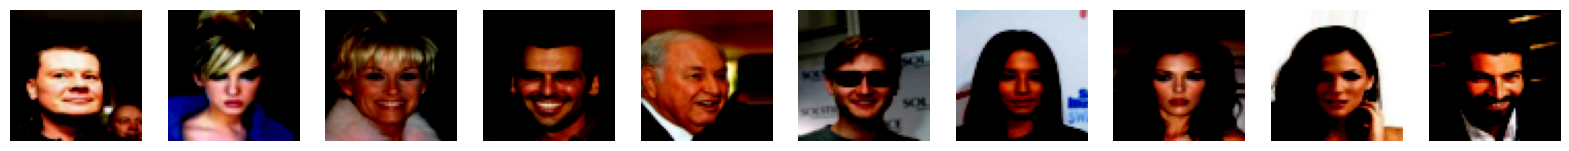

In [53]:
def show_image_batch(images, labels, num_images=10):
  
    images = images[:num_images]
    images = images.permute(0, 2, 3, 1)  
    images = images.cpu().numpy()  
  
    fig, axes = plt.subplots(1, num_images, figsize=(20, 15))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i])
        ax.axis('off')
       
    plt.show()


for images, labels in loader:
    
    show_image_batch(images, labels, num_images=10)
    break  

Processing Batches: 100%|██████████| 1583/1583 [09:06<00:00,  2.90it/s]


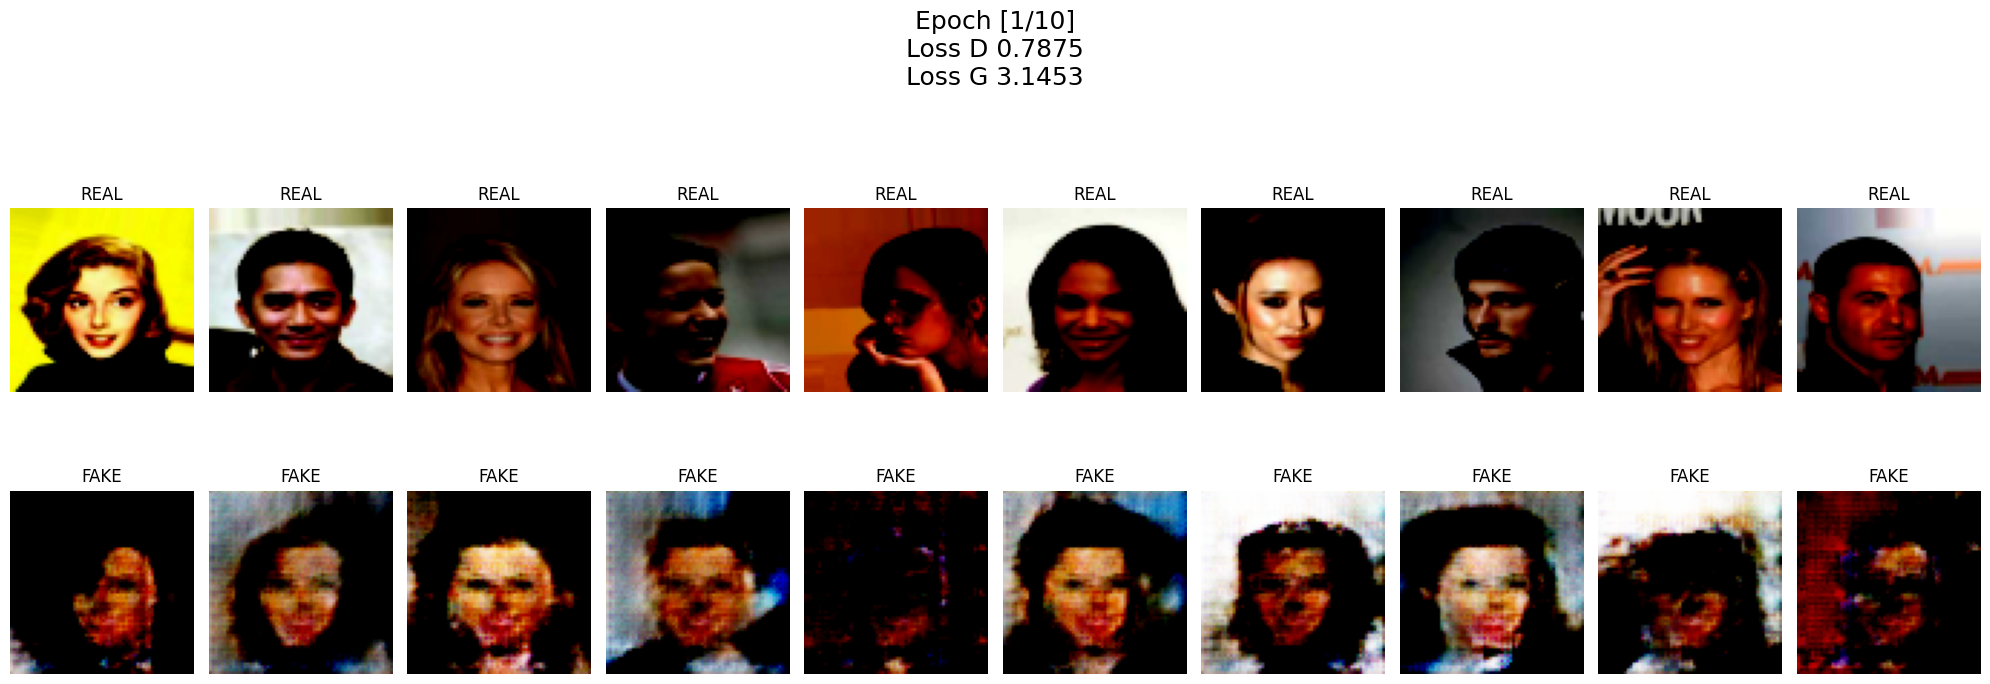

Processing Batches: 100%|██████████| 1583/1583 [09:03<00:00,  2.91it/s]


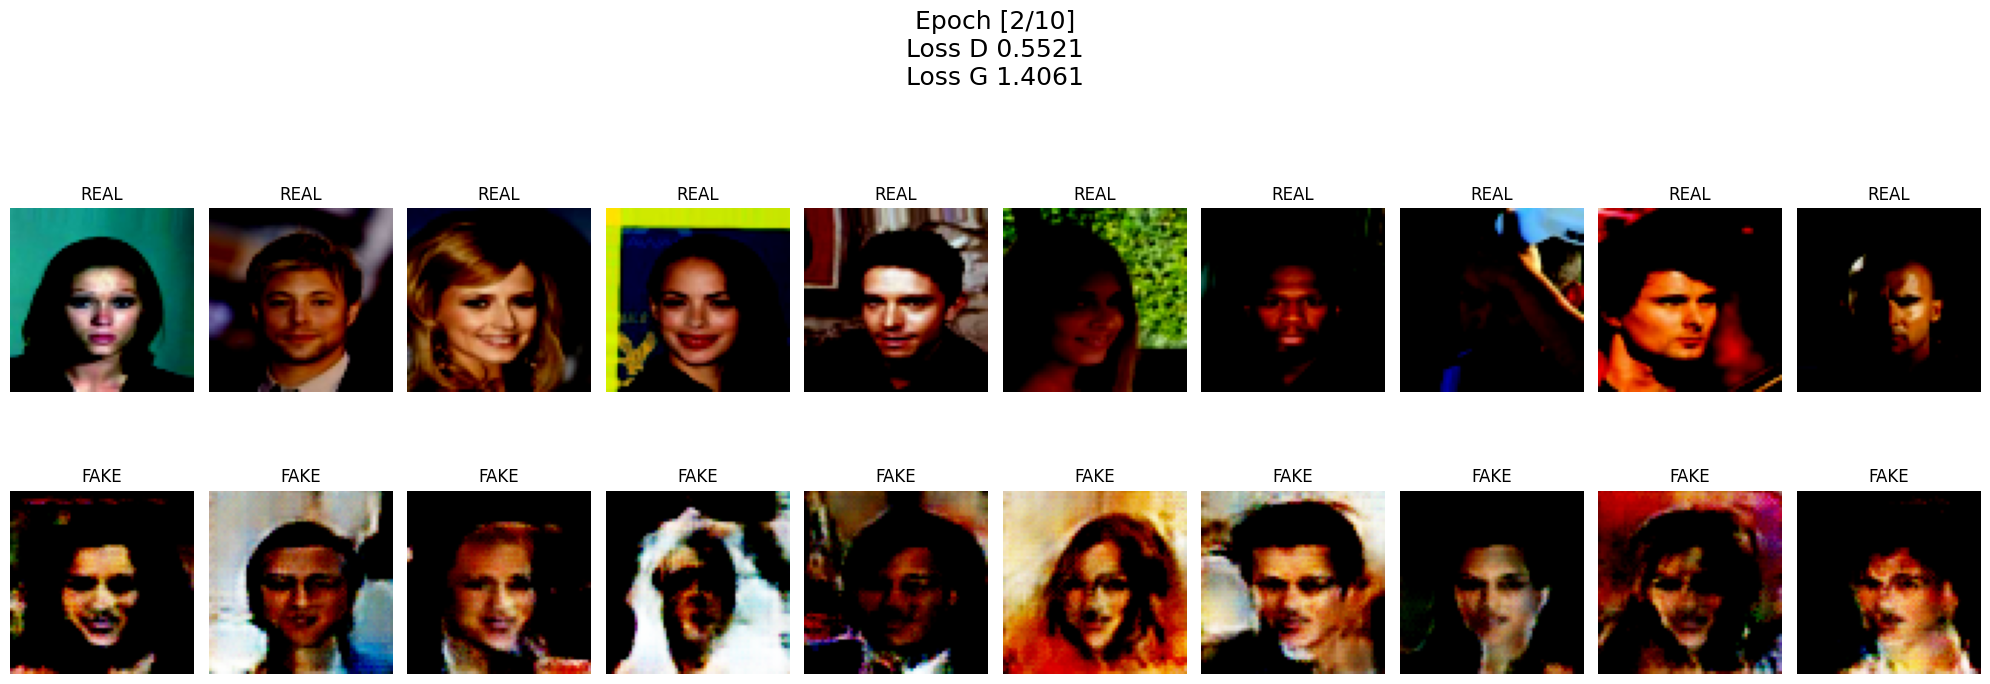

Processing Batches: 100%|██████████| 1583/1583 [09:01<00:00,  2.92it/s]


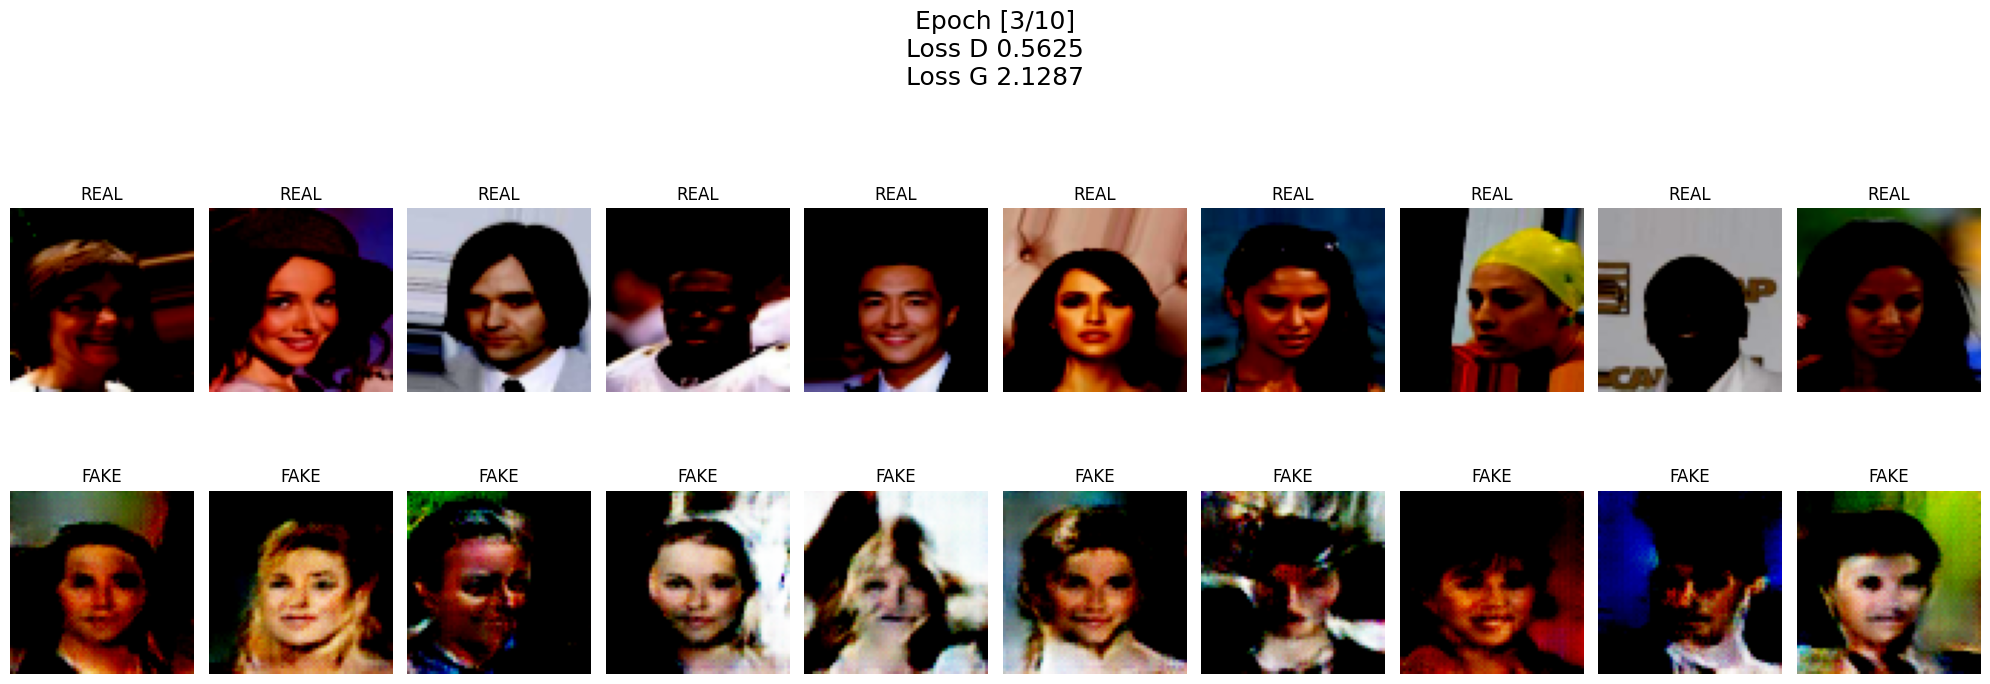

Processing Batches: 100%|██████████| 1583/1583 [08:59<00:00,  2.93it/s]


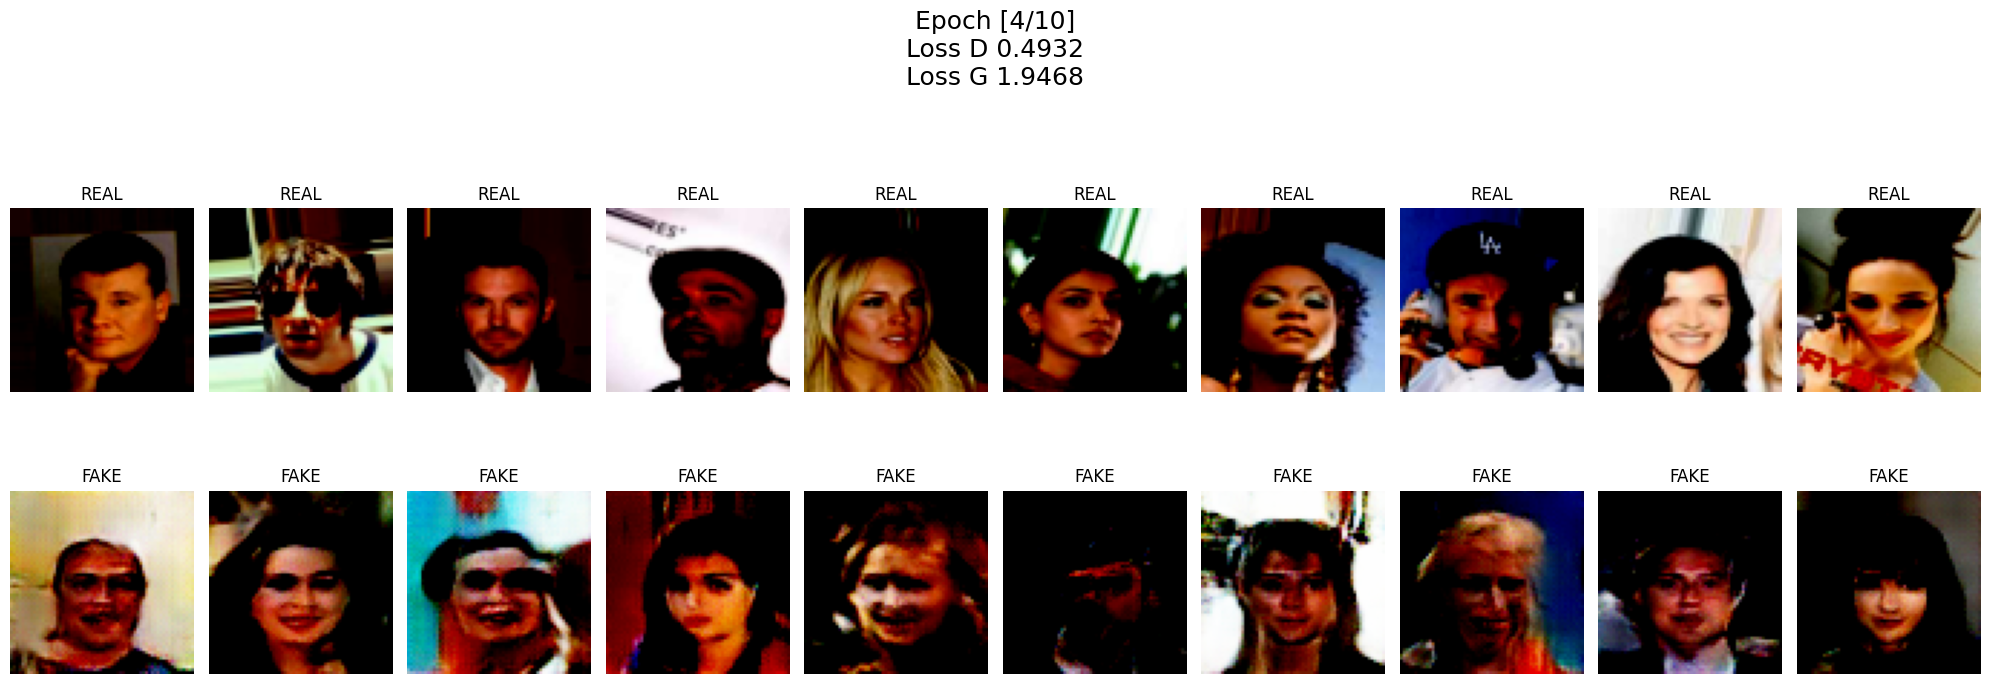

Processing Batches: 100%|██████████| 1583/1583 [09:00<00:00,  2.93it/s]


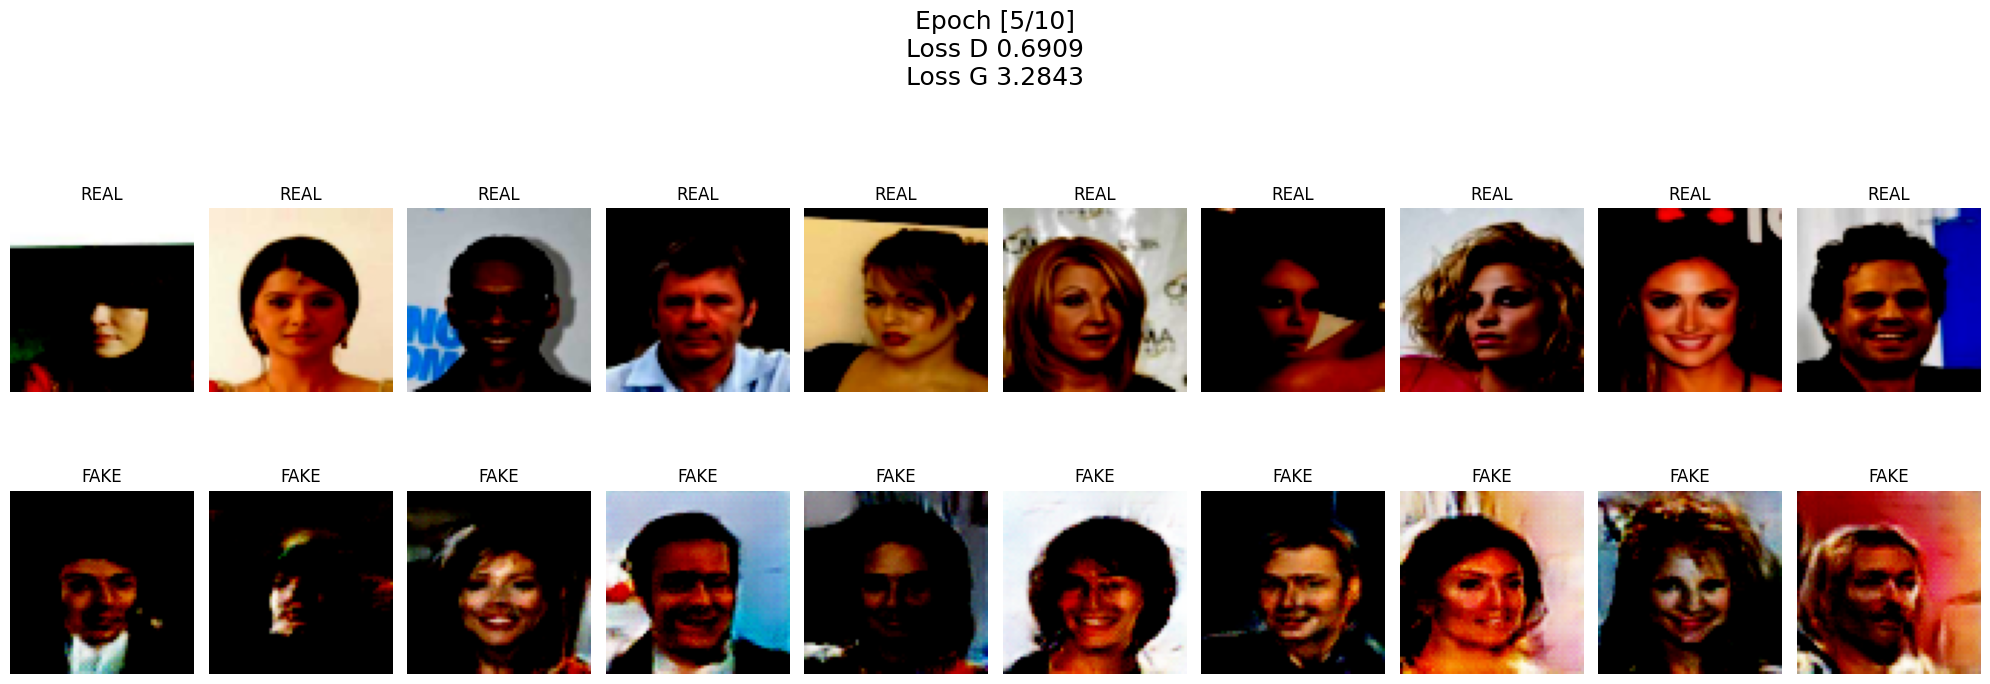

Processing Batches: 100%|██████████| 1583/1583 [09:00<00:00,  2.93it/s]


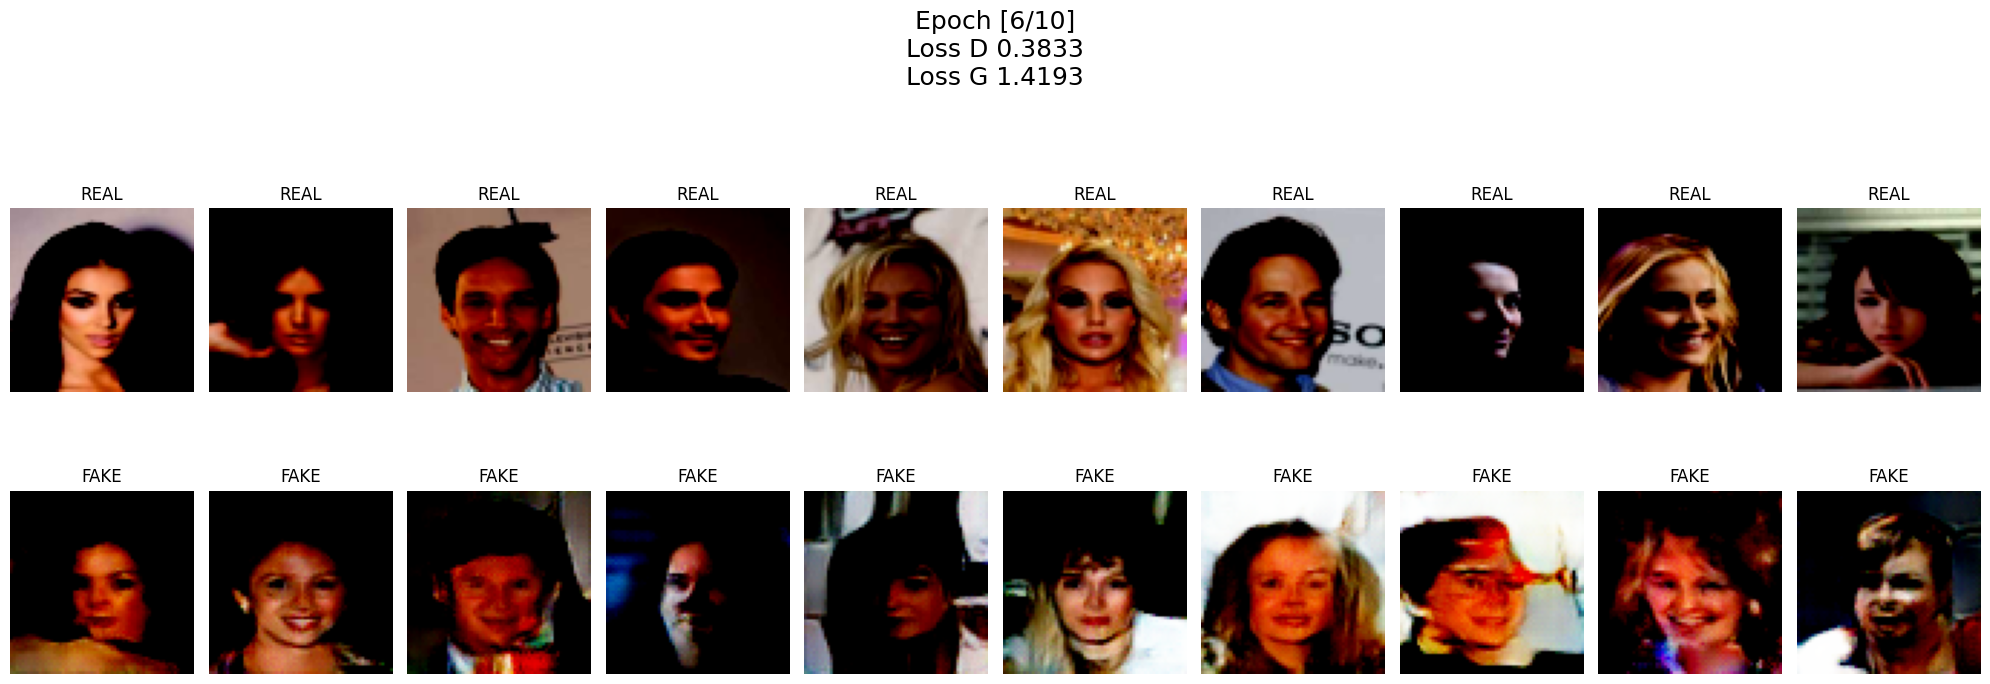

Processing Batches: 100%|██████████| 1583/1583 [09:00<00:00,  2.93it/s]


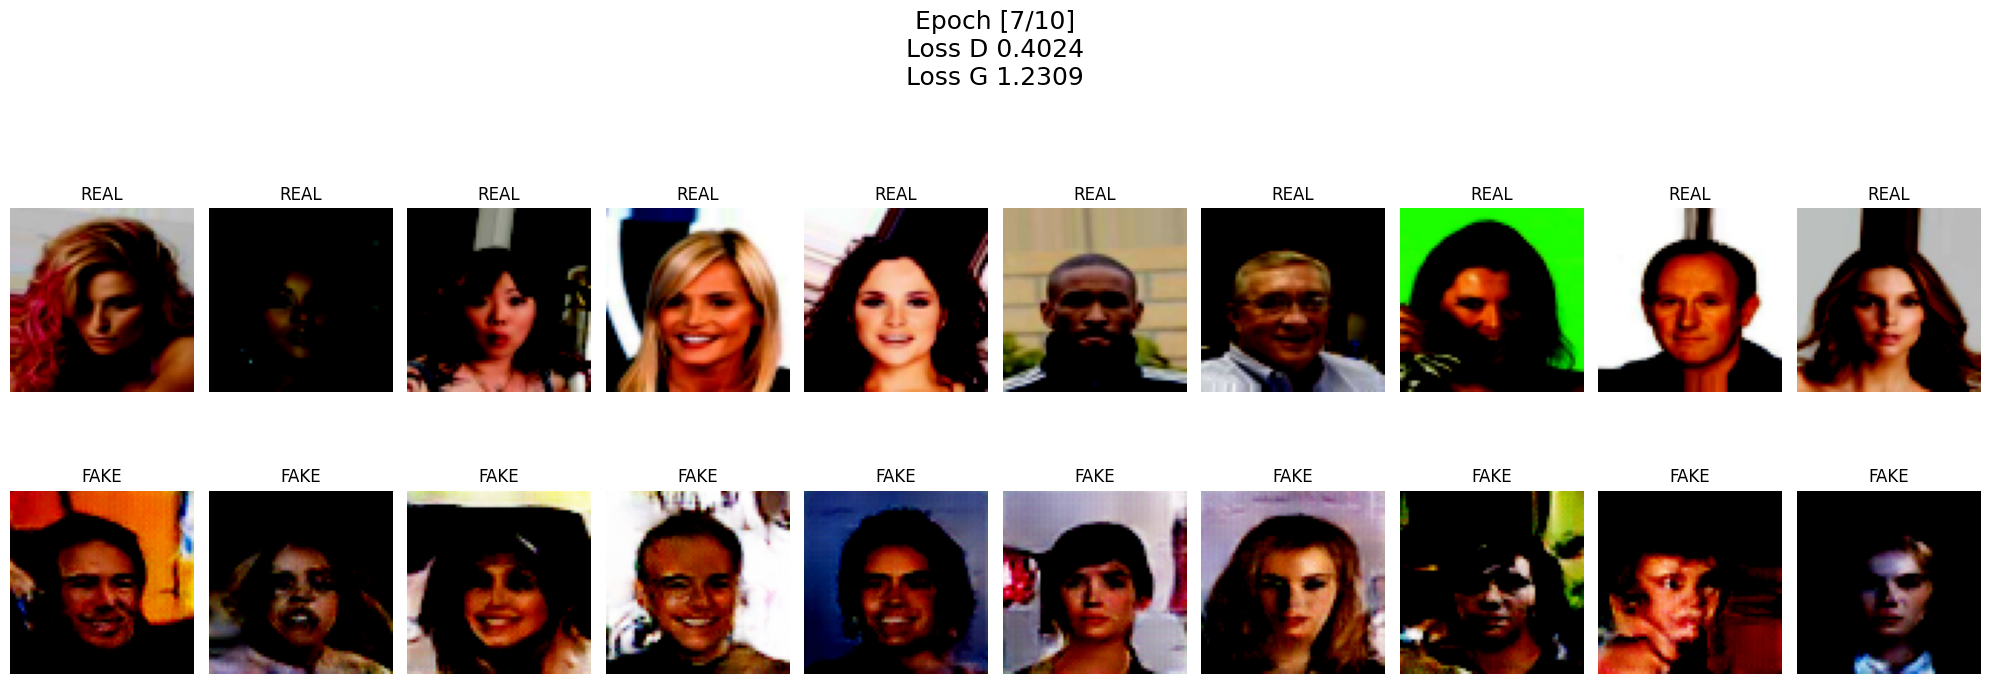

Processing Batches: 100%|██████████| 1583/1583 [08:59<00:00,  2.93it/s]


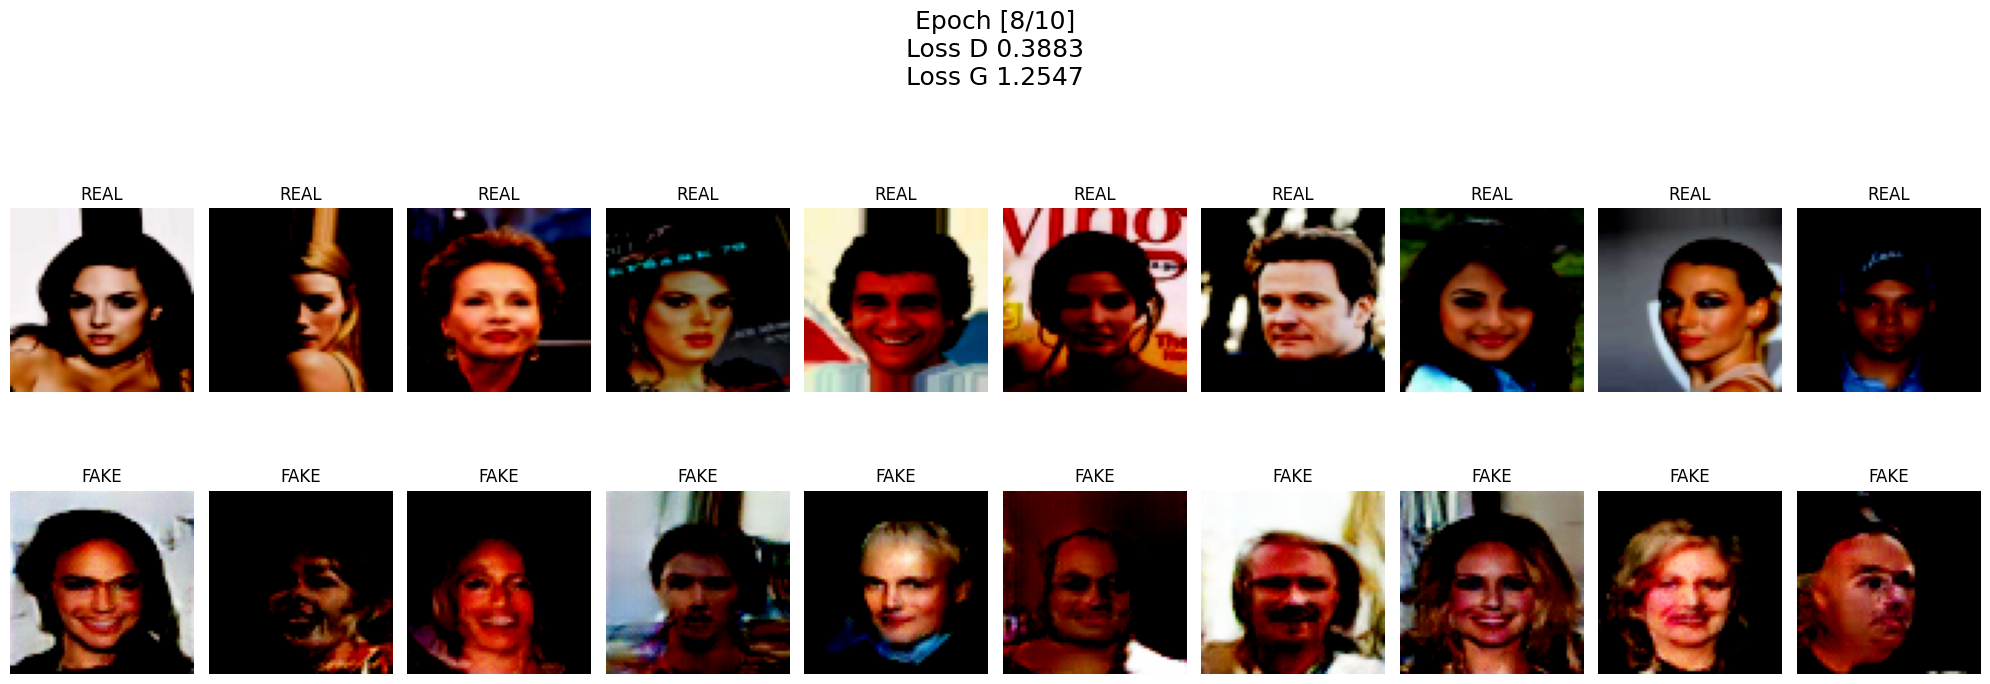

Processing Batches: 100%|██████████| 1583/1583 [08:59<00:00,  2.93it/s]


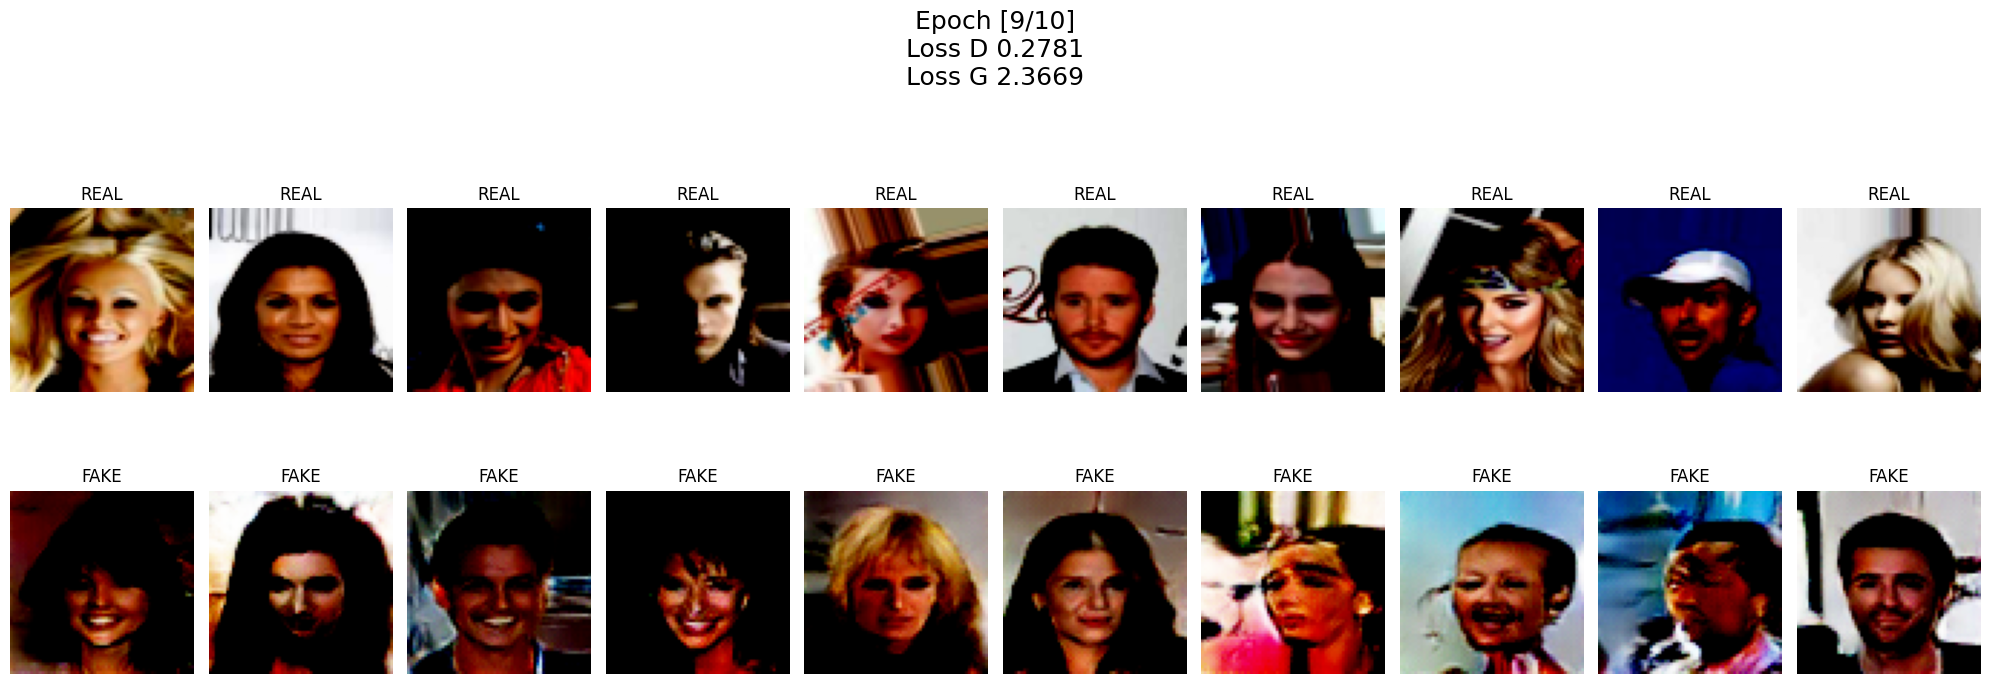

Processing Batches:  97%|█████████▋| 1536/1583 [08:43<00:16,  2.93it/s]

In [ ]:
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(tqdm(loader, desc='Processing Batches')):
        
        real = real.to(device)
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1,1)).to(device)
        fake = gen(noise)
        ### Train Discriminator: max log(D(real)) + log(1-D(G(z))
        
        disc_real = disc(real).reshape(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).reshape(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()
        
        ### Train Generator min log(1-D(G(z))) <-> max log(D(G(z)))
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()
        
     
    

    fixed_noise = torch.randn(10, Z_DIM, 1, 1).to(device)
    real = real.view(-1, CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE)

    with torch.no_grad():
        fake = gen(fixed_noise)
    fake = fake.view(-1, CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE)
            
    real = real[:10]
    fake = fake[:10]
 
    real = real.permute(0, 2, 3, 1)   
    fake = fake.permute(0, 2, 3, 1)  

    real = real.cpu().numpy()
    fake = fake.cpu().numpy()


    fig, axes = plt.subplots(2, 10, figsize=(20, 8))
    for i in range(10):
        # Real images
        axes[0, i].imshow(real[i])
        axes[0, i].set_title('REAL')
        axes[0, i].axis('off')

        # Fake images
        axes[1, i].imshow(fake[i])
        axes[1, i].set_title('FAKE')
        axes[1, i].axis('off')

    plt.suptitle(f"Epoch [{epoch+1}/{NUM_EPOCHS}]\nLoss D {lossD:.4f}\nLoss G {lossG:.4f}", fontsize=18)
    plt.tight_layout()
    plt.show()